Test hdp

In [1]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

hdp = HdpModel(common_corpus, common_dictionary)

In [4]:
unseen_document = [(1, 3.), (2, 4)]
doc_hdp = hdp[unseen_document]
print(doc_hdp)

[(0, 0.03341908699644691), (1, 0.023504962286821224), (2, 0.01777962700359986), (3, 0.013239159594342766), (26, 0.8727486754656921)]


In [ ]:
from pprint import pprint
topic_info = hdp.print_topics()
pprint(topic_info)

In [3]:
print(common_corpus)
print(common_dictionary)

[[(0, 1), (1, 1), (2, 1)], [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(2, 1), (5, 1), (7, 1), (8, 1)], [(1, 1), (5, 2), (8, 1)], [(3, 1), (6, 1), (7, 1)], [(9, 1)], [(9, 1), (10, 1)], [(9, 1), (10, 1), (11, 1)], [(4, 1), (10, 1), (11, 1)]]
Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)


# Load raw data

In [4]:
import pandas as pd
import numpy as np

raw = pd.read_csv('./raw.csv')
print(raw.head())

# discard flows with zero flow size
raw = raw[raw['td'] > 0]

        srcip      dstip  srcport  dstport proto            ts       td  pkt  \
0  1730436467  719036359        0        0  ICMP  1.458298e+15  305.636   62   
1  1730436466  719036359        0        0  ICMP  1.458298e+15  305.636   62   
2  3627282195  719036341        0        0  ICMP  1.458298e+15  300.000   31   
3   607268605  719036341        0        0  ICMP  1.458298e+15  299.996   31   
4  3628038305  719036341        0        0  ICMP  1.458298e+15  299.996   31   

    byt        type  
0  1736  background  
1  1736  background  
2   992  background  
3   992  background  
4   992  background  


# Count and filter src-dst pairs

In [5]:
unique_srcip = raw['srcip'].unique()
print(unique_srcip.shape)

unique_dstip = raw['dstip'].unique()
print(unique_dstip.shape)

unique_ip = np.unique(np.concatenate((unique_srcip, unique_dstip)))
print(unique_ip.shape)

sd_group = raw.groupby(['srcip', 'dstip'])
print(sd_group.size())

# discard src-dst pairs with flow count < MIN_FLOW_COUNT
MIN_FLOW_COUNT = 200
sd_group = sd_group.filter(lambda x: len(x) >= MIN_FLOW_COUNT).groupby(['srcip', 'dstip'])
print(sd_group.size())

(37525,)
(2409,)
(39933,)
srcip       dstip    
536873666   719036255    1
539108506   719036255    1
539297583   719036255    1
539696996   719034631    1
539696997   719034631    1
                        ..
4294767861  719036255    1
4294822371  719034633    1
            719034846    1
            719036090    1
4294867603  719036255    1
Length: 55590, dtype: int64
srcip       dstip    
604662897   719035603     309
606925716   719034662    1613
607267976   719035241     262
607267978   719035236     225
609744588   719035603     224
                         ... 
3747622580  719035635     202
3748704652  719035635     223
3755740565  719036090     715
3755839582  719035013     258
4028566301  719036255     537
Length: 304, dtype: int64


In [6]:
total_interarrival_list = []

for name, group in sd_group:
    interarrival_list = list(np.diff(group['ts']))
    total_interarrival_list.extend(interarrival_list)

total_flow_size_list = raw['td']

print(f"len(sd_group) = {len(sd_group)}")

len(sd_group) = 304


In [7]:
# avoid type3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 15})
import matplotlib.pyplot as plt
from collections import Counter

# color-blindness friendly
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

def vals2cdf(vals):
    dist_dict = dict(Counter(vals))
    dist_dict = {k: v for k, v in sorted(dist_dict.items(), key = lambda x: x[0])}
    x = dist_dict.keys()

    pdf = np.asarray(list(dist_dict.values()), dtype=float) / float(sum(dist_dict.values()))
    cdf = np.cumsum(pdf)
    return x, cdf


# syn_df_dict: {name: dict}
def plot_cdf(vals, xlabel, ylabel, plot_loc, label,  x_logscale=False, y_logscale=False):
    plt.clf()
    x, cdf = vals2cdf(vals)
    plt.plot(x, cdf, label=label, color=CB_color_cycle[0], linewidth=5)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if x_logscale:
        plt.xscale('log')
    if y_logscale:
        plt.yscale('log')

    plt.savefig(plot_loc, bbox_inches="tight", dpi=300)

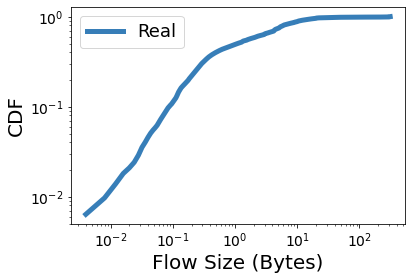

In [8]:
import os

plot_dir = "plot"
sub_dir = "raw_all"
os.makedirs(os.path.join(plot_dir, sub_dir), exist_ok=True)

# plot cdf of interarrival time
plot_cdf(total_interarrival_list, "Interarrival Time (s)", "CDF", os.path.join(plot_dir, sub_dir, "interarrival_cdf.pdf"), "Real", x_logscale=False, y_logscale=False)
plot_cdf(total_interarrival_list, "Interarrival Time (s)", "CDF", os.path.join(plot_dir, sub_dir, "interarrival_cdf_logscale.pdf"), "Real", x_logscale=True, y_logscale=True)

# plot cdf of flow size
plot_cdf(total_flow_size_list, "Flow Size (Bytes)", "CDF", os.path.join(plot_dir, sub_dir, "flow_size_cdf.pdf"), "Real", x_logscale=False, y_logscale=False)
plot_cdf(total_flow_size_list, "Flow Size (Bytes)", "CDF", os.path.join(plot_dir, sub_dir, "flow_size_cdf_logscale.pdf"), "Real", x_logscale=True, y_logscale=True)

# Preprocessing

In [70]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [9]:
import math

NUM_BIN_FLOW_SIZE = 1e6
NUM_BIN_INTERARRIVAL = 1e6

USE_LOG_SCALE = False
EPSILON = 1e-6

min_flow_size, max_flow_size = min(total_flow_size_list), max(total_flow_size_list)
min_interarrival, max_interarrival = min(total_interarrival_list), max(total_interarrival_list)
print(f"max_flow_size: {max_flow_size}, min_flow_size: {min_flow_size}")
print(f"max_interarrival: {max_interarrival}, min_interarrival: {min_interarrival}")

if not USE_LOG_SCALE:
    # linear binning
    bin_size_flow_size = (max_flow_size - min_flow_size) / NUM_BIN_FLOW_SIZE
    bin_size_interarrival = (max_interarrival - min_interarrival) / NUM_BIN_INTERARRIVAL
    print(f"linear_bin_size_flow_size: {bin_size_flow_size}, linear_bin_size_interarrival: {bin_size_interarrival}")
else:
    # log scale binning
    bin_size_flow_size = (math.log(max_flow_size + EPSILON) - math.log(min_flow_size + EPSILON)) / NUM_BIN_FLOW_SIZE
    bin_size_interarrival = (math.log(max_interarrival + EPSILON) - math.log(min_interarrival + EPSILON)) / NUM_BIN_INTERARRIVAL
    print(f"log_bin_size_flow_size: {bin_size_flow_size}, log_bin_size_interarrival: {bin_size_interarrival}")

def get_bin_idx(val, bin_size, min_val, log_scale=False):
    if not log_scale:
        bin_idx = math.floor((val - min_val) / bin_size)
    else:
        bin_idx = math.floor((math.log(val + EPSILON) - math.log(min_val + EPSILON)) / bin_size)
    return bin_idx

def get_bin_idx_list(vals, bin_size, min_val, log_scale=False):
    bin_idx_list = []
    for val in vals:
        bin_idx = get_bin_idx(val, bin_size, min_val, log_scale)
        bin_idx_list.append(bin_idx)
    return bin_idx_list

max_flow_size: 312.948, min_flow_size: 0.004
max_interarrival: 643092000.0, min_interarrival: 0.0
linear_bin_size_flow_size: 0.00031294399999999995, linear_bin_size_interarrival: 643.092


In [10]:
# find non-zero minimum flow size and interarrival time
min_nonzero_flow_size = min([x for x in total_flow_size_list if x > 0])
min_nonzero_interarrival = min([x for x in total_interarrival_list if x > 0])
print(f"min_nonzero_flow_size: {min_nonzero_flow_size}, min_nonzero_interarrival: {min_nonzero_interarrival}")

# count number zero interarrival time
num_zero_interarrival = total_interarrival_list.count(0)
percentage_zero_interarrival = num_zero_interarrival / len(total_interarrival_list)
print(f"num_zero_interarrival: {num_zero_interarrival}, percentage: {percentage_zero_interarrival}")

min_nonzero_flow_size: 0.004, min_nonzero_interarrival: 4000.0
num_zero_interarrival: 22327, percentage: 0.1836827036988285


In [11]:
# get flow indices for each src-dst pair based on flow size and interarrival time
corpus = []
corpus_dict = {}
src_dst_list = []
raw_flows = []
    
for name, group in sd_group:
    flow_size_list = group['td']
    interarrival_list = [0.0] + list(np.diff(group['ts']))

    flow_size_bin_idx_list = get_bin_idx_list(flow_size_list, bin_size_flow_size, min_flow_size, log_scale=USE_LOG_SCALE)
    interarrival_bin_idx_list = get_bin_idx_list(interarrival_list, bin_size_interarrival ,min_interarrival, log_scale=USE_LOG_SCALE)
    flow_idx_list = [str(flow_size_bin_idx) + "_" + str(interarrival_bin_idx) 
                    for flow_size_bin_idx, interarrival_bin_idx in zip(flow_size_bin_idx_list, interarrival_bin_idx_list)] 
    corpus.append(flow_idx_list)

    src_id, dst_id = name
    corpus_dict[f"{src_id}_{dst_id}"] = flow_idx_list

    src_dst_list.append(f"{src_id}_{dst_id}")
    raw_flows.extend(group[["srcip", "dstip", "ts", "td"]].values.tolist())

In [12]:
# save corpus
import json
import os
import pandas as pd

corpus_dir = "corpus"
bin_method = "log" if USE_LOG_SCALE else "linear"
hyper_str = f"min_flow_count-{MIN_FLOW_COUNT}, num_bin_flow_size-{NUM_BIN_FLOW_SIZE}, num_bin_interarrival-{NUM_BIN_INTERARRIVAL}"

os.makedirs(os.path.join(corpus_dir, hyper_str, bin_method), exist_ok=True)

with open(os.path.join(corpus_dir, hyper_str, bin_method, "corpus.json"), "w") as f:
    json.dump(corpus, f)
with open(os.path.join(corpus_dir, hyper_str, bin_method, "corpus_dict.json"), "w") as f:
    json.dump(corpus_dict, f)
with open(os.path.join(corpus_dir, hyper_str, "src_dst_list.json"), "w") as f:
    json.dump(src_dst_list, f)
    
df = pd.DataFrame(raw_flows, columns=["srcip", "dstip", "ts", "td"])
df.to_csv(os.path.join(corpus_dir, hyper_str, bin_method, "raw_flows.csv"), index=False)

# Training

In [13]:
from gensim.corpora import Dictionary

# create dictionary
dictionary = Dictionary(corpus)

# save dictionary
dictionary.save(os.path.join(corpus_dir, hyper_str, bin_method, "dictionary.dict"))

# bag-of-words representation of the corpus
corpus_bow = [dictionary.doc2bow(text) for text in corpus]

In [14]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 200
chunksize = 2000
passes = 50 # training iterations
iterations = 500 # inference iterations
eval_every = None  # Don't evaluate model perplexity, takes too much time.

_ = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

model_name = str(model)

# Save model

In [15]:
from pprint import pprint

print(len(corpus))
doc_topics = model.get_document_topics(corpus_bow)
print(len(doc_topics))

# transform doc_topics to a matrix of size (num_src_dst_pair, num_topics)
doc_topics_matrix = np.zeros((len(doc_topics), num_topics))
for i, doc_topic in enumerate(doc_topics):
    for topic, prob in doc_topic:
        doc_topics_matrix[i][topic] = prob
    # normalize
    doc_topics_matrix[i] = doc_topics_matrix[i] / np.sum(doc_topics_matrix[i])
print(doc_topics_matrix)

model_dir = "model"
os.makedirs(os.path.join(model_dir, hyper_str, bin_method, model_name), exist_ok=True)

# save doc_topics_matrix
np.save(os.path.join(model_dir, hyper_str, bin_method, model_name, "doc_topics_matrix.npy"), doc_topics_matrix)

# save model
model.save(os.path.join(model_dir, hyper_str, bin_method, model_name, "model.model"))

# save config
config = {
    "MIN_FLOW_COUNT": MIN_FLOW_COUNT,
    "NUM_BIN_FLOW_SIZE": NUM_BIN_FLOW_SIZE,
    "NUM_BIN_INTERARRIVAL": NUM_BIN_INTERARRIVAL,
    "min_flow_size": min_flow_size,
    "max_flow_size": max_flow_size,
    "min_nonzero_interarrival": min_nonzero_interarrival,
    "percentage_zero_interarrival": percentage_zero_interarrival,
    "min_interarrival": min_interarrival,
    "max_interarrival": max_interarrival,
    "bin_size_flow_size": bin_size_flow_size,
    "bin_size_interarrival": bin_size_interarrival,
    "EPSILON": EPSILON,
    "USE_LOG_SCALE": USE_LOG_SCALE,
    "model_name": model_name,
    "bin_method": bin_method,
}

with open(os.path.join(model_dir, hyper_str, bin_method, model_name, "config.json"), "w") as f:
    json.dump(config, f)

304
304
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
topic_terms_matrix = model.get_topics()
print(topic_terms_matrix.shape)

(200, 66858)


# Generating

In [17]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np
import json

corpus_dir = "corpus"

# load config
with open(os.path.join(model_dir, hyper_str, bin_method, model_name, "config.json"), "r") as f:
    config = json.load(f)
NUM_BIN_FLOW_SIZE = config["NUM_BIN_FLOW_SIZE"]
NUM_BIN_INTERARRIVAL = config["NUM_BIN_INTERARRIVAL"]
min_flow_size = config["min_flow_size"]
max_flow_size = config["max_flow_size"]
min_interarrival = config["min_interarrival"]
max_interarrival = config["max_interarrival"]
bin_size_flow_size = config["bin_size_flow_size"]
bin_size_interarrival = config["bin_size_interarrival"]
EPSILON = config["EPSILON"]
USE_LOG_SCALE = config["USE_LOG_SCALE"]
model_name = config["model_name"]
bin_method = config["bin_method"]
min_non_zero_interarrival = config["min_nonzero_interarrival"]
percentage_zero_interarrival = config["percentage_zero_interarrival"]

# load lda model
model = LdaModel.load(os.path.join(model_dir, hyper_str, bin_method, model_name, "model.model"))
dictionary = Dictionary.load(os.path.join(corpus_dir, hyper_str, bin_method, "dictionary.dict"))
doc_topics_matrix = np.load(os.path.join(model_dir, hyper_str, bin_method, model_name, "doc_topics_matrix.npy"))
topic_terms_matrix = model.get_topics()

# load src_dst_list
with open(os.path.join(corpus_dir, hyper_str, "src_dst_list.json"), "r") as f:
    src_dst_list = json.load(f)

In [18]:
import math

# convert discrete flow size and interarrival time to continuous values
def sample(bin_idx, bin_size, min_val, log_scale=False):
    low = bin_idx * bin_size
    high = (bin_idx + 1) * bin_size
    val = np.random.uniform(low=low, high=high)
    if log_scale:
        return math.exp(val + math.log(min_val + EPSILON))
    else:
        return val + min_val

In [19]:
# generate flows
from tqdm import tqdm
import pandas as pd
import os
import random

output_dir = "output"
bin_method = "log" if USE_LOG_SCALE else "linear"
pair_wise_dir = os.path.join(output_dir, hyper_str, bin_method, model_name, "pair_wise")
os.makedirs(pair_wise_dir, exist_ok=True)

time_limit = 5e8
syn_flows = []
it_list = []
for idx, src_dst in tqdm(enumerate(src_dst_list)):
    srcip, dstip = src_dst.split("_")
    ts = 0
    os.makedirs(os.path.join(pair_wise_dir, src_dst), exist_ok=True)
    pair_wise_flows = []
    while ts < time_limit:
        # sample topic
        theta = doc_topics_matrix[idx]
        topic_idx = np.argmax(np.random.multinomial(1, theta))
        # sample flow
        beta = topic_terms_matrix[topic_idx]
        beta /= (np.sum(beta) + EPSILON)
        # print(np.sum(beta))
        flow_idx = np.argmax(np.random.multinomial(1, beta))
        flow_str = dictionary[flow_idx] # "flow-size-bin-idx_interarrival-bin-idx"
        flow_size_bin_idx, interarrival_bin_idx = flow_str.split("_")
        flow_size_bin_idx = int(flow_size_bin_idx)
        interarrival_bin_idx = int(interarrival_bin_idx)
        # sample flow size and interarrival time
        flow_size = sample(flow_size_bin_idx, bin_size_flow_size, min_flow_size, log_scale=USE_LOG_SCALE)
        interarrival = sample(interarrival_bin_idx, bin_size_interarrival, min_interarrival, log_scale=USE_LOG_SCALE)
        while interarrival < min_non_zero_interarrival:
            if random.random() < percentage_zero_interarrival / 100:
                break
            interarrival = sample(interarrival_bin_idx, bin_size_interarrival, min_interarrival, log_scale=USE_LOG_SCALE)
        # update timestamp
        ts += interarrival
        # add flow
        syn_flows.append((srcip, dstip, ts, flow_size))
        it_list.append(interarrival)
        pair_wise_flows.append((srcip, dstip, ts, flow_size))
    pd.DataFrame(pair_wise_flows, columns=["srcip", "dstip", "ts", "td"]).to_csv(os.path.join(pair_wise_dir, src_dst, "syn.csv"), index=False)

# save flows
df = pd.DataFrame(syn_flows, columns=["srcip", "dstip", "ts", "td"])
df.to_csv(os.path.join(output_dir, hyper_str, bin_method, model_name, "syn_flows.csv"), index=False)

304it [02:04,  2.45it/s]


2022-11-10 15:43:04,815 : INFO : maxp pruned
2022-11-10 15:43:04,830 : INFO : cmap pruned
2022-11-10 15:43:04,831 : INFO : kern dropped
2022-11-10 15:43:04,831 : INFO : post pruned
2022-11-10 15:43:04,832 : INFO : FFTM dropped
2022-11-10 15:43:04,838 : INFO : GPOS pruned
2022-11-10 15:43:04,845 : INFO : GSUB pruned
2022-11-10 15:43:04,847 : INFO : name pruned
2022-11-10 15:43:05,231 : INFO : glyf pruned
2022-11-10 15:43:05,233 : INFO : Added gid0 to subset
2022-11-10 15:43:05,234 : INFO : Added first four glyphs to subset
2022-11-10 15:43:05,234 : INFO : Closing glyph list over 'GSUB': 32 glyphs before
2022-11-10 15:43:05,235 : INFO : Glyph names: ['.notdef', '.null', 'C', 'D', 'F', 'I', 'S', 'T', 'a', 'e', 'eight', 'five', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'v', 'y', 'zero']
2022-11-10 15:43:05,240 : INFO : Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 39

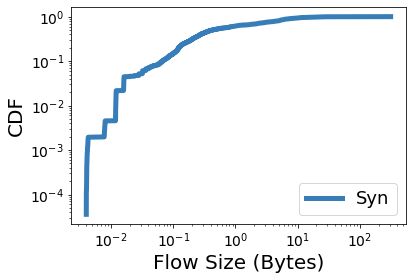

In [130]:
# plot cdf of interarrival time
plot_cdf(it_list, "Interarrival Time (s)", "CDF", os.path.join(output_dir, hyper_str, bin_method, model_name, "interarrival_cdf.pdf"), "Syn", x_logscale=False, y_logscale=False)
plot_cdf(it_list, "Interarrival Time (s)", "CDF", os.path.join(output_dir, hyper_str, bin_method, model_name, "interarrival_cdf_logscale.pdf"), "Syn", x_logscale=True, y_logscale=True)

# plot cdf of flow size
plot_cdf(df["td"], "Flow Size (Bytes)", "CDF", os.path.join(output_dir, hyper_str, bin_method, model_name, "flow_size_cdf.pdf"), "Syn", x_logscale=False, y_logscale=False)
plot_cdf(df["td"], "Flow Size (Bytes)", "CDF", os.path.join(output_dir, hyper_str, bin_method, model_name, "flow_size_cdf_logscale.pdf"), "Syn", x_logscale=True, y_logscale=True)

# Plot cdf between raw and syn traces

In [123]:
def plot_cdf2(raw_vals, syn_vals_dict, xlabel, ylabel, plot_loc, x_logscale=False, y_logscale=False):
    plt.clf()
    x, cdf = vals2cdf(raw_vals)
    plt.plot(x, cdf, label="Real", color=CB_color_cycle[0], linewidth=5)
    idx = 1
    for method, syn_vals in syn_vals_dict.items():
        x, cdf = vals2cdf(syn_vals)
        plt.plot(x, cdf, label=method, color=CB_color_cycle[idx], linewidth=1.5)
        idx += 1
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if x_logscale:
        plt.xscale('log')
    if y_logscale:
        plt.yscale('log')
    plt.savefig(plot_loc, bbox_inches="tight", dpi=300)

2022-11-10 15:45:44,941 : INFO : maxp pruned
2022-11-10 15:45:44,955 : INFO : cmap pruned
2022-11-10 15:45:44,955 : INFO : kern dropped
2022-11-10 15:45:44,956 : INFO : post pruned
2022-11-10 15:45:44,957 : INFO : FFTM dropped
2022-11-10 15:45:44,960 : INFO : GPOS pruned
2022-11-10 15:45:44,966 : INFO : GSUB pruned
2022-11-10 15:45:44,969 : INFO : name pruned
2022-11-10 15:45:44,977 : INFO : glyf pruned
2022-11-10 15:45:44,979 : INFO : Added gid0 to subset
2022-11-10 15:45:44,981 : INFO : Added first four glyphs to subset
2022-11-10 15:45:44,982 : INFO : Closing glyph list over 'GSUB': 31 glyphs before
2022-11-10 15:45:44,983 : INFO : Glyph names: ['.notdef', '.null', 'C', 'D', 'F', 'I', 'R', 'S', 'T', 'a', 'e', 'eight', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'v', 'y', 'zero']
2022-11-10 15:45:44,987 : INFO : Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 23, 25, 27, 38, 39, 41, 44, 53, 54, 55

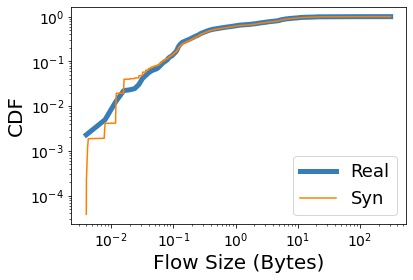

In [133]:
import os

os.makedirs(os.path.join(plot_dir, hyper_str, bin_method, model_name), exist_ok=True)

raw_df = pd.read_csv(os.path.join(corpus_dir, hyper_str, bin_method, "raw_flows.csv"))
raw_it_list = []
for name, group in raw_df.groupby(["srcip", "dstip"]):
    it_list = [0] + list(np.diff(group["ts"]))
    raw_it_list.extend(it_list)

syn_df = pd.read_csv(os.path.join(output_dir, hyper_str, bin_method, model_name, "syn_flows.csv"))
syn_it_list = []
for name, group in syn_df.groupby(["srcip", "dstip"]):
    it_list = [0] + list(np.diff(group["ts"]))
    syn_it_list.extend(it_list)

# plot cdf of interarrival time
plot_cdf2(raw_it_list, {"Syn": syn_it_list}, "Interarrival Time (s)", "CDF", os.path.join(plot_dir, hyper_str, bin_method, model_name, "interarrival_cdf2.pdf"), x_logscale=False, y_logscale=False)
plot_cdf2(raw_it_list, {"Syn": syn_it_list}, "Interarrival Time (s)", "CDF", os.path.join(plot_dir, hyper_str, bin_method, model_name, "interarrival_cdf2_logscale.pdf"), x_logscale=True, y_logscale=True)

# plot cdf of flow size
plot_cdf2(raw_df["td"], {"Syn": syn_df["td"]}, "Flow Size (Bytes)", "CDF", os.path.join(plot_dir, hyper_str, bin_method, model_name, "flow_size_cdf2.pdf"), x_logscale=False, y_logscale=False)
plot_cdf2(raw_df["td"], {"Syn": syn_df["td"]}, "Flow Size (Bytes)", "CDF", os.path.join(plot_dir, hyper_str, bin_method, model_name, "flow_size_cdf2_logscale.pdf"), x_logscale=True, y_logscale=True)

# Generate flow traces for a target src-dst pair

In [159]:
raw_df = pd.read_csv(os.path.join(corpus_dir, hyper_str, bin_method, "raw_flows.csv"))
print(raw_df.head())

for name, group in tqdm(raw_df.groupby(["srcip", "dstip"])):
    srcip, dstip = name
    group.to_csv(os.path.join(pair_wise_dir, f"{int(srcip)}_{int(dstip)}", "raw.csv"), index=False)

         srcip        dstip            ts     td
0  604662897.0  719035603.0  1.458298e+15  0.132
1  604662897.0  719035603.0  1.458298e+15  0.084
2  604662897.0  719035603.0  1.458298e+15  0.096
3  604662897.0  719035603.0  1.458298e+15  0.092
4  604662897.0  719035603.0  1.458298e+15  0.088


100%|██████████| 304/304 [00:01<00:00, 278.22it/s]


In [160]:
for idx, src_dst in tqdm(enumerate(src_dst_list)):
    raw_df = pd.read_csv(os.path.join(pair_wise_dir, src_dst, "raw.csv"))
    syn_df = pd.read_csv(os.path.join(pair_wise_dir, src_dst, "syn.csv"))

    # plot cdf of interarrival time
    plot_cdf2(np.diff(raw_df["ts"]), {"Syn": np.diff(syn_df["ts"])}, "Interarrival Time (s)", "CDF", os.path.join(pair_wise_dir, src_dst, "interarrival_cdf2.pdf"), x_logscale=False, y_logscale=False)
    plot_cdf2(np.diff(raw_df["ts"]), {"Syn": np.diff(syn_df["ts"])}, "Interarrival Time (s)", "CDF", os.path.join(pair_wise_dir, src_dst, "interarrival_cdf2_logscale.pdf"), x_logscale=True, y_logscale=True)

    # plot cdf of flow size
    plot_cdf2(raw_df["td"], {"Syn": syn_df["td"]}, "Flow Size (Bytes)", "CDF", os.path.join(pair_wise_dir, src_dst, "flow_size_cdf2.pdf"), x_logscale=False, y_logscale=False)
    plot_cdf2(raw_df["td"], {"Syn": syn_df["td"]}, "Flow Size (Bytes)", "CDF", os.path.join(pair_wise_dir, src_dst, "flow_size_cdf2_logscale.pdf"), x_logscale=True, y_logscale=True)

0it [00:00, ?it/s]2022-11-10 16:46:55,690 : INFO : maxp pruned
2022-11-10 16:46:55,704 : INFO : cmap pruned
2022-11-10 16:46:55,706 : INFO : kern dropped
2022-11-10 16:46:55,707 : INFO : post pruned
2022-11-10 16:46:55,707 : INFO : FFTM dropped
2022-11-10 16:46:55,711 : INFO : GPOS pruned
2022-11-10 16:46:55,716 : INFO : GSUB pruned
2022-11-10 16:46:55,717 : INFO : name pruned
2022-11-10 16:46:55,730 : INFO : glyf pruned
2022-11-10 16:46:55,732 : INFO : Added gid0 to subset
2022-11-10 16:46:55,733 : INFO : Added first four glyphs to subset
2022-11-10 16:46:55,734 : INFO : Closing glyph list over 'GSUB': 31 glyphs before
2022-11-10 16:46:55,734 : INFO : Glyph names: ['.notdef', '.null', 'C', 'D', 'F', 'I', 'R', 'S', 'T', 'a', 'e', 'eight', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'v', 'y', 'zero']
2022-11-10 16:46:55,737 : INFO : Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 23, 25, 27, 38, 39, 

# Kolmogorov–Smirnov test for each pair

In [20]:
from scipy.stats import ks_2samp
import pandas as pd
import numpy as np

raw_df = pd.read_csv(os.path.join(corpus_dir, hyper_str, bin_method, "raw_flows.csv"))
syn_df = pd.read_csv(os.path.join(output_dir, hyper_str, bin_method, model_name, "syn_flows.csv"))
res_td = ks_2samp(raw_df["td"], syn_df["td"])
res_it = ks_2samp(np.diff(raw_df["ts"]), np.diff(syn_df["ts"]))

print(f"KS test for flow size: {res_td}")
print(f"KS test for interarrival time: {res_it}")

KS test for flow size: KstestResult(statistic=0.03690250233920597, pvalue=3.174171841660102e-50)
KS test for interarrival time: KstestResult(statistic=0.18099848150593456, pvalue=0.0)


# JS Divergence for raw and syn traces of each pair 

In [2]:
# compute EMD for raw and syn flows
import pandas as pd
import numpy as np
import os
from scipy.stats import wasserstein_distance
import json
from tqdm import tqdm

dir_path = "output\min_flow_count-200, num_bin_flow_size-1000000.0, num_bin_interarrival-1000000.0\linear\LdaModel(num_terms=66858, num_topics=200, decay=0.5, chunksize=2000)\pair_wise"
paths = os.listdir(dir_path)
files = [os.path.join(dir_path, path) for path in paths]
print(f"file count: {len(files)}")

for file in tqdm(files):
    raw_df = pd.read_csv(os.path.join(file, "raw.csv"))
    syn_df = pd.read_csv(os.path.join(file, "syn.csv"))
    
    # compute EMD for flow size
    raw_td = raw_df["td"].values
    syn_td = syn_df["td"].values
    raw_td = raw_td / np.sum(raw_td)
    syn_td = syn_td / np.sum(syn_td)
    emd_td = wasserstein_distance(raw_td, syn_td)

    # compute EMD for interarrival time
    raw_it = np.diff(raw_df["ts"].values)
    syn_it = np.diff(syn_df["ts"].values)
    raw_it = raw_it / np.sum(raw_it)
    syn_it = syn_it / np.sum(syn_it)
    emd_it = wasserstein_distance(raw_it, syn_it)

    with open(os.path.join(file, "emd.json"), "w") as f:
        json.dump({"emd_td": emd_td, "emd_it": emd_it}, f)


file count: 304


# Draw pair-wise figures

In [9]:
import random

PAIR_SIZE = 16
pair_wise_dir = "output\min_flow_count-200, num_bin_flow_size-1000000.0, num_bin_interarrival-1000000.0\linear\LdaModel(num_terms=66858, num_topics=200, decay=0.5, chunksize=2000)\pair_wise"

random.seed(0) # for reproducibility
all_src_dst = os.listdir(pair_wise_dir)
sampled_src_dst = random.sample(all_src_dst, PAIR_SIZE)

In [ ]:
import pandas as pd
import numpy as np

MAX_FLOW_NUM = 200 # maximum number of flows to plot
QUANTILE_BINS = 20 # number of quantile bins
fs_matrix = np.zeros((PAIR_SIZE, MAX_FLOW_NUM))
it_matrix = np.zeros((PAIR_SIZE, MAX_FLOW_NUM))

for idx, src_dst in enumerate(sampled_src_dst):
    raw_df = pd.read_csv(os.path.join(pair_wise_dir, src_dst, "raw.csv"))
    # syn_df = pd.read_csv(os.path.join(pair_wise_dir, src_dst, "syn.csv"))

    print(len(raw_df["td"]))

    # transform flow size and interarrival time to quantile
    quantile_fs = pd.qcut(raw_df["td"], QUANTILE_BINS, labels=False)
    quantile_it = pd.qcut(np.diff(raw_df["ts"]), QUANTILE_BINS, labels=False)

    if len(quantile_fs > MAX_FLOW_NUM):
        fs_matrix[idx] = quantile_fs[:MAX_FLOW_NUM]
    else:
        fs_matrix[idx, :len(quantile_fs)] = quantile_fs
    
    if len(quantile_it) > MAX_FLOW_NUM:
        it_matrix[idx] = quantile_it[:MAX_FLOW_NUM]
    else:
        it_matrix[idx, :len(quantile_it)] = quantile_it

In [ ]:
tmp_ts = [1, 1, 1, 2, 2, 2]
res = pd.qcut(tmp_ts, 5, labels=False)
print(res)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

colors_map = plt.cm.rainbow(np.linspace(0, 1, PAIR_SIZE))
colors_map = np.array(colors_map)
offset = np.zeros(PAIR_SIZE)
plt.figure(figsize=(40,5))
for idx in range(MAX_FLOW_NUM):
    plt.barh(y=np.arange(PAIR_SIZE, 0, -1), width=fs_matrix[:, idx], height=0.8, left=offset, color=colors_map, linewidth=0.0, edgecolor='#adb5bd')
    offset += fs_matrix[:, idx]
    offset += it_matrix[:, idx]

plt.xticks([])  # remove x ticks
ylabels = [fr"\br{x}" for x in range(PAIR_SIZE, 0, -2)]
plt.yticks(np.arange(1, PAIR_SIZE + 1, 2), ylabels, fontsize=20)  # remove y ticks
plt.ylabel(r"\bf{Src-Dst Pair}", fontsize=25)
plt.savefig("flow_size.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [18]:
ys = [fr"\bf{x}" for x in range(16, 0, -2)]
print(ys)

['\\bf16', '\\bf14', '\\bf12', '\\bf10', '\\bf8', '\\bf6', '\\bf4', '\\bf2']


3D pair-wise